In [ ]:
import kagglehub
abusive_language_detection_path = kagglehub.dataset_download('micro1234/abusive-language-detection')
print(abusive_language_detection_path)

In [2]:
ROOT = '/kaggle/input/abusive-language-detection'

In [3]:
def merge_DS1():
    train = pd.read_csv(f"{ROOT}/DS1/train.csv")
    test = pd.read_csv(f"{ROOT}/DS1/test.csv")
    test_labels = pd.read_csv(f"{ROOT}/DS1/test_labels.csv")

    test_combined = test.merge(test_labels, on="id")
    test_cleaned = test_combined[(test_combined[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] != -1).all(axis=1)]
    print(f"Train samples = {len(train)}")
    print(f"Test cleaned samples = {len(test_cleaned)}")

    combined_DS1 = pd.concat([train, test_cleaned], ignore_index=True)

    return combined_DS1

def map_class(row):
    """
    Maps the format from DS2 to DS1 using class label.
    0 = hate speech
    1 = offensive language
    2 = neither
    """
    if row['class'] == 0:  # hate speech
        return pd.Series([1, 0, 1, 0, 1, 1])
    elif row['class'] == 1:  # offensive language
        return pd.Series([1, 0, 1, 0, 1, 0])
    else:  # neither
        return pd.Series([0, 0, 0, 0, 0, 0])


def change_DS2_format():
    df = pd.read_csv(f"{ROOT}/DS2/twitter_data.csv")
    df = df.rename(columns={"tweet": "comment_text"})

    df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] = df.apply(map_class, axis=1)

    df_cleaned = df[['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

    # Add id
    df_cleaned.insert(0, 'id', [f"ds2_{i:06d}" for i in range(len(df_cleaned))])

    return df_cleaned

def load_data(with_DS3=False):
    ds1 = merge_DS1()
    ds2 = change_DS2_format()
    
    if with_DS3:
        ds3 = pd.read_csv(f'{ROOT}/DS3/processed_lyrics_dataset.csv')
        ds4 = pd.read_csv(f'{ROOT}/DS4/identity_hate.csv')
        return pd.concat([ds1, ds2, ds3, ds4], ignore_index=True)
    
    return pd.concat([ds1, ds2], ignore_index=True)

In [4]:
import re
import string
import spacy
import pandas as pd
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

In [5]:
# laod english model
nlp = spacy.load("en_core_web_sm")

# download nltk data
nltk.download('punkt_tab')          # For word_tokenize
nltk.download('averaged_perceptron_tagger_eng')  # For pos_tag
nltk.download('wordnet')        # For lemmatizer
nltk.download('omw-1.4')        # WordNet's multilingual support (helps lemmatization)
nltk.download('stopwords')   

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

contractions = {
    "can't": "cannot",
    "won't": "will not",
    "i'm": "i am",
    "it's": "it is",
    "don't": "do not",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "we're": "we are",
    "they're": "they are",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "didn't": "did not",
    "doesn't": "does not",
    "couldn't": "could not",
    "that's": "that is",
    "what's": "what is",
    "where's": "where is",
    "who's": "who is",
    "how's": "how is",
    "there's": "there is",
    "when's": "when is",
    "let's": "let us",
}


# pos tag -> wordnet pos
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def expand_contractions(text):
    pattern = re.compile(r'\b(' + '|'.join(contractions.keys()) + r')\b')
    return pattern.sub(lambda x: contractions[x.group()], text)

def normalize_abusive(text):
    patterns = [
        (r'a\$+\$', 'ass'),
        (r'f[\*@#%]+k', 'fuck'),
        (r'muth[a@]+f[\*@#%]+', 'motherfuck'),
        (r'sh[\*@#%]+t', 'shit'),
        (r'b[i1]+tch', 'bitch'),
        (r'n[i!1]+gg[a@]+[r]?s?', 'nigger'),
        (r'd[i!1]+c[k]+', 'dick'),
        (r'di[c]+k', 'dick'),
        (r'd1ck', 'dick'),
    ]
    for pattern, repl in patterns:
        text = re.sub(pattern, repl, text, flags=re.IGNORECASE)
    return text


def remove_emojis(text):
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags
                            "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def preprocess_text(text, is_basic=True):
    # basic cleaning
    text = str(text)
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    if is_basic:
        return text.strip().lower()
    
    text = expand_contractions(text) # it's -> it is
    text = normalize_abusive(text) # d1ck -> dick
    text = remove_emojis(text) # remove emojies
    text = re.sub(r'(.)\1{2,}', r'\1\1', text) # anddddd -> andd(reduce repeated charachter)
    text = re.sub(r'[^A-Za-z\s]', ' ', text)  # remove special characters
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # remove stopwords
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

    # lemmatize
    tagged_tokens = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]


    # doc = nlp(" ".join(lemmatized))
    # entities = [(ent.text, ent.label_) for ent in doc.ents]

    return " ".join(lemmatized)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import tensorflow as tf

2025-05-24 17:08:03.865649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748106483.884502     168 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748106483.891359     168 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
df = load_data(with_DS3=True)
df['clean_text'] = df['comment_text'].apply(preprocess_text)

Train samples = 159571
Test cleaned samples = 63978


/tmp/ipykernel_168/1109203945.py:84: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(text, "html.parser").get_text()


In [9]:
from transformers import DebertaV2TokenizerFast, DebertaV2ForSequenceClassification, TrainingArguments, Trainer

from sklearn.preprocessing import MultiLabelBinarizer
from datasets import Dataset
import torch

from sklearn.metrics import classification_report
import numpy as np


In [10]:
def prepare_and_split(df):
    df = df.copy()
    # Drop comment_text
    df.drop(columns=['comment_text'], inplace=True)

    # Drop rows with empty
    df = df[df['clean_text'].notna() & (df['clean_text'].str.strip() != '')]

    df = shuffle(df, random_state=42).reset_index(drop=True)


    label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    X = df['clean_text']
    Y = df[label_cols]

    # 80% train, 10%, 10%
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test


In [11]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_and_split(df)

In [12]:
def train_deberta(X_train, Y_train, X_val, Y_val, label_names, model_name='microsoft/deberta-v3-base', max_len=128):
    # Load tokenizer
    tokenizer = DebertaV2TokenizerFast.from_pretrained(model_name)

    def tokenize_function(example):
        return tokenizer(example["text"], truncation=True, padding="max_length", max_length=max_len)

    # Convert inputs to numpy
    train_text_np = X_train.to_numpy() if hasattr(X_train, 'to_numpy') else np.array(X_train)
    train_labels_np = Y_train.astype("float32").to_numpy() if hasattr(Y_train, 'to_numpy') else np.array(Y_train.astype("float32"))

    val_text_np = X_val.to_numpy() if hasattr(X_val, 'to_numpy') else np.array(X_val)
    val_labels_np = Y_val.astype("float32").to_numpy() if hasattr(Y_val, 'to_numpy') else np.array(Y_val.astype("float32"))

    # Build HuggingFace datasets
    train_ds = Dataset.from_dict({
        "text": train_text_np,
        "labels": train_labels_np
    })
    val_ds = Dataset.from_dict({
        "text": val_text_np,
        "labels": val_labels_np
    })

    # Tokenize
    train_ds = train_ds.map(tokenize_function, batched=True)
    val_ds = val_ds.map(tokenize_function, batched=True)

    train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # Load DeBERTa model
    model = DebertaV2ForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label_names),
        problem_type="multi_label_classification"
    )

    # Training configuration
    training_args = TrainingArguments(
        output_dir="./deberta_output",
        save_strategy="no",
        logging_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.01
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
    )

    # Train
    trainer.train()
    try:
        trainer.save_model("/kaggle/working/deberta_final_model")
    except Exception as err:
        print(f"Cannot save model because {err}")

    return trainer, tokenizer, model

In [13]:
from torch.utils.data import DataLoader, TensorDataset

def evaluate_bert(trainer, tokenizer, model, X_test, Y_test, label_names, max_len=128, threshold=0.5, batch_size=32):
    device = next(model.parameters()).device

    # Tokenize
    encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_len, return_tensors="pt")
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])

    loader = DataLoader(dataset, batch_size=batch_size)

    model.eval()
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask = [x.to(device) for x in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits.detach().cpu()).numpy()
            all_probs.append(probs)

    # Concatenate all batches
    all_probs = np.vstack(all_probs)
    preds = (all_probs >= threshold).astype(int)

    print(classification_report(Y_test.values, preds, target_names=label_names, zero_division=0))

    return preds

In [14]:
!wandb login --relogin '581b627005619a3c7065007c3fa67ea2502100ff'

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [16]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

trainer, tokenizer, model = train_deberta(X_train, Y_train, X_val, Y_val, label_cols)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/332407 [00:00<?, ? examples/s]

Map:   0%|          | 0/41551 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: barakat-anthonio (barakat-anthonio-upb) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss


In [ ]:
preds = evaluate_bert(trainer, tokenizer, model, X_test, Y_test, label_cols)

               precision    recall  f1-score   support

        toxic       0.91      0.92      0.91      5789
 severe_toxic       0.59      0.49      0.54       232
      obscene       0.94      0.94      0.94      5299
       threat       0.87      0.86      0.86       327
       insult       0.89      0.91      0.90      3711
identity_hate       0.89      0.88      0.88      1351

    micro avg       0.91      0.91      0.91     16709
    macro avg       0.85      0.83      0.84     16709
 weighted avg       0.90      0.91      0.91     16709
  samples avg       0.17      0.17      0.17     16709



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_actual_vs_predicted(Y_true, Y_pred, label_names):
    """
    Plot actual vs predicted values per label (summed across samples).

    Args:
        Y_true: true labels (numpy array or DataFrame)
        Y_pred: predicted labels (numpy array)
        label_names: list of label names
    """
    if not isinstance(Y_true, np.ndarray):
        Y_true = Y_true.values

    Y_true = np.array(Y_true)
    Y_pred = np.array(Y_pred)

    # Sum actual and predicted positives per label
    actual = Y_true.sum(axis=0)
    predicted = Y_pred.sum(axis=0)

    x = np.arange(len(label_names))

    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.2, actual, width=0.4, label='Actual', color='blue')
    plt.bar(x + 0.2, predicted, width=0.4, label='Predicted', color='orange')
    plt.xticks(x, label_names, rotation=45)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Actual vs Predicted Labels (Per Class)')
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

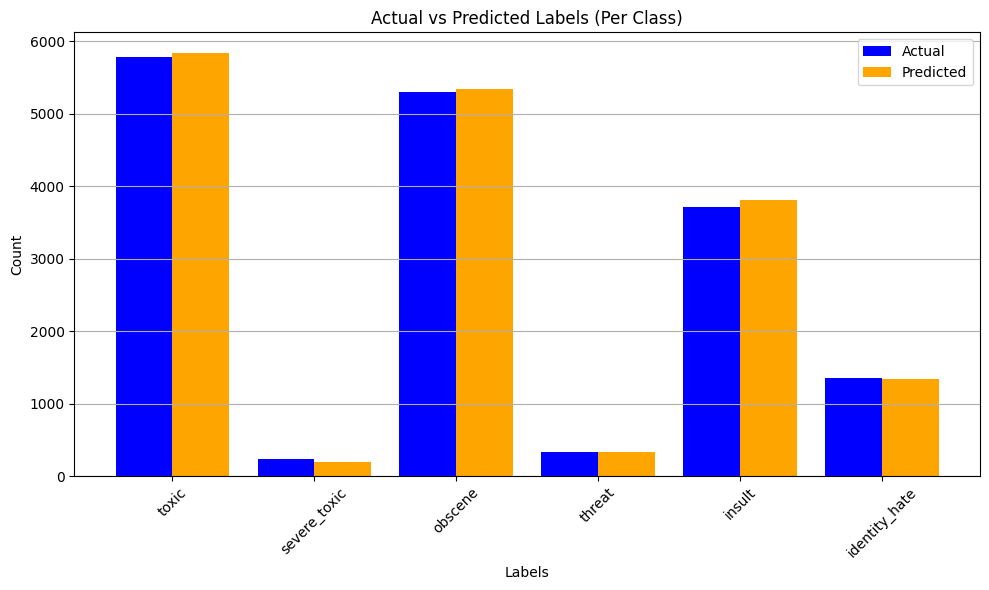

In [ ]:
plot_actual_vs_predicted(Y_test, preds, Y_test.columns)